<a href="https://colab.research.google.com/github/mabuice/AMATH_Visual_Coding/blob/main/Homework_Decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
<h3> This notebook will explore decoding using the Allen Brain Observatory data </h3>
    
In this notebook, we'll look at decoding using different models, different definitions of the design matrix, and different neural populations.


In [1]:
# @title Run to initialize Allen Brain Observatory on Colab {display-mode: "form" }
# run only once per runtime/session, and only if running in colab
# the runtime will need to restart after
%%capture
!apt install s3fs
!pip install allensdk
!mkdir -p /data/allen-brain-observatory/
!s3fs allen-brain-observatory /data/allen-brain-observatory/ -o public_bucket=1

### Standard imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn

### Allen Brain Observatory set up

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The command below returns a list of dictionaries containing information about the experiment sessions.  As we saw in the main notebook, you can use optional arguments to specify subsets of experiment sessions.  (Hint:  use the help function to see other ways of choosing sessions.)
</div>

In [4]:
exps = boc.get_ophys_experiments()

In [5]:
pd.DataFrame(exps)

,id,imaging_depth,targeted_structure,cre_line,reporter_line,acquisition_age_days,experiment_container_id,session_type,donor_name,specimen_name,fail_eye_tracking
0,566752133,175,VISl,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),116,564425775,three_session_C2,283147,Emx1-IRES-Cre;Camk2a-tTA;Ai93-283147,True
1,653123586,275,VISl,Rorb-IRES2-Cre,Ai93(TITL-GCaMP6f),111,653123584,three_session_C2,352471,Rorb-IRES2-Cre;Camk2a-tTA;Ai93-352471,True
2,577225417,275,VISl,Vip-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),105,575772104,three_session_C2,296710,Vip-IRES-Cre;Ai148-296710,False
3,556353209,375,VISam,Rbp4-Cre_KL100,Ai93(TITL-GCaMP6f),101,555327033,three_session_A,271750,Rbp4-Cre;Camk2a-tTA;Ai93-271750,True
4,510390912,275,VISal,Rorb-IRES2-Cre,Ai93(TITL-GCaMP6f),80,511500480,three_session_A,232623,Rorb-IRES2-Cre;Camk2a-tTA;Ai93-232623,False
...,...,...,...,...,...,...,...,...,...,...,...
1363,577820172,275,VISam,Rorb-IRES2-Cre,Ai93(TITL-GCaMP6f),110,576411244,three_session_B,295995,Rorb-IRES2-Cre;Camk2a-tTA;Ai93-295995,False
1364,648389302,275,VISp,Slc17a7-IRES2-Cre,Ai93(TITL-GCaMP6f),108,647155120,three_session_B,347751,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347751,False
1365,510517609,375,VISpm,Rbp4-Cre_KL100,Ai93(TITL-GCaMP6f),75,511511006,three_session_B,233442,Rbp4-Cre;Camk2a-tTA;Ai93-233442,False
1366,547560448,350,VISal,Nr5a1-Cre,Ai93(TITL-GCaMP6f),107,546328009,three_session_C2,261969,Nr5a1-Cre;Camk2a-tTA;Ai93-261969,False


The following function will grab the data_set object for a given session_id.  The last two lines will extract the dF/F traces and the stimulus table for a given stimulus type.  

Some other stimulus types are `natural_scenes` and `static_gratings`.

In [7]:
session_id = 541513979
exps = boc.get_ophys_experiments(cell_specimen_ids=[541513979], stimuli=['drifting_gratings'])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)
timestamps, dff = data_set.get_dff_traces()
stim_table = data_set.get_stimulus_table('drifting_gratings')


**Exercise 1:** Use a different decoder and repeat the same analysis.  Good decoders to try are Logistic Regression, Support Vector Machine, K-Means.

Logistic Regression:
https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html

Support Vector Machine:
https://scikit-learn.org/1.6/modules/generated/sklearn.svm.SVC.html

(Note:  look through the documentation to see what parameters govern these decoders.  How should you set them?  What effect do they have on the performance of your classifier?)


Training Accuracy: 0.811
Testing Accuracy: 0.777


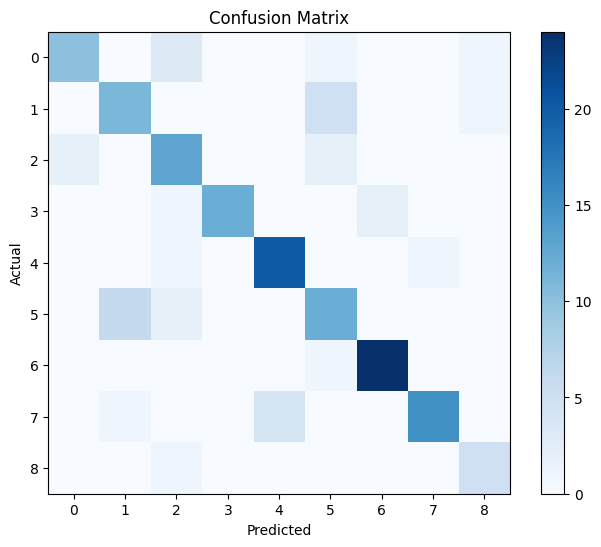

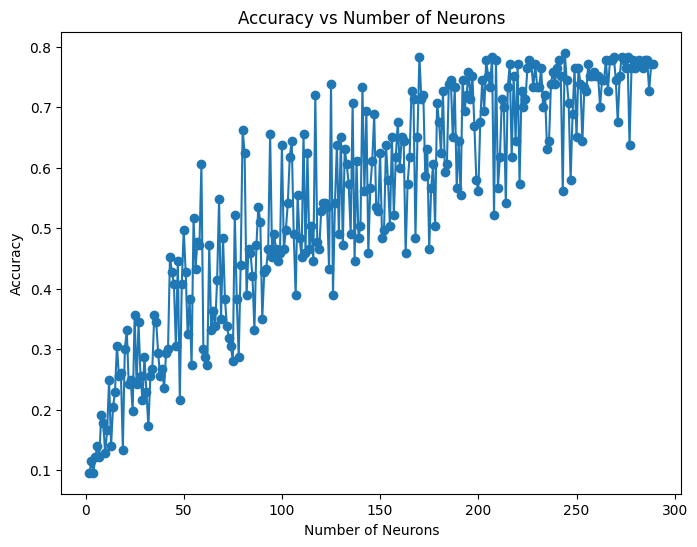

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

num_neurons = dff.shape[0]
num_trials = stim_table.shape[0]
activity = np.zeros([num_trials, num_neurons])
stim = []

for i, row in stim_table.iterrows():
    activity[i] = dff[:, int(row.start):int(row.end)].mean(axis=1)
    stim.append(str(row.orientation) if np.isfinite(row.orientation) else 'blank')

stim = np.array(stim)

# Split into train and test sets
test_index = int(0.75 * num_trials)
activity_train, activity_test = activity[:test_index], activity[test_index:]
stim_train, stim_test = stim[:test_index], stim[test_index:]

# Train Logistic Regression model
classifier = LogisticRegression(max_iter=500)
classifier.fit(activity_train, stim_train)

# Predict results
stim_train_pred = classifier.predict(activity_train)
stim_test_pred = classifier.predict(activity_test)

# Compute accuracy
train_acc = accuracy_score(stim_train, stim_train_pred)
test_acc = accuracy_score(stim_test, stim_test_pred)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Testing Accuracy: {test_acc:.3f}")

# Confusion Matrix
conf_matrix = confusion_matrix(stim_test, stim_test_pred)
plt.figure(figsize=(8,6))
plt.imshow(conf_matrix, interpolation='none', cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Accuracy vs Number of Cells Decoded
performance = []
for n in range(2, num_neurons):
    selected_neurons = np.random.choice(num_neurons, n, replace=False)
    activity_train_n, activity_test_n = activity_train[:, selected_neurons], activity_test[:, selected_neurons]
    model_n = LogisticRegression(max_iter=500)
    model_n.fit(activity_train_n, stim_train)
    stim_test_pred_n = model_n.predict(activity_test_n)
    performance.append(accuracy_score(stim_test, stim_test_pred_n))

plt.figure(figsize=(8,6))
plt.plot(range(2, num_neurons), performance, marker='o')
plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Neurons')
plt.show()


**Exercise 2:** Use a different stimulus type.  In addition to ‘drifting_gratings’, there are also ‘natural_scenes’ and ‘static_gratings’.  Find a session with these stimuli and try decoding the stimulus condition.

(Hint:  use the function given above to get a list of experiments and convert it to a dataframe).*italicized text*
</div>

Selected session ID: 566752133, Stimulus: natural_scenes
Training Accuracy: 0.700
Testing Accuracy: 0.360


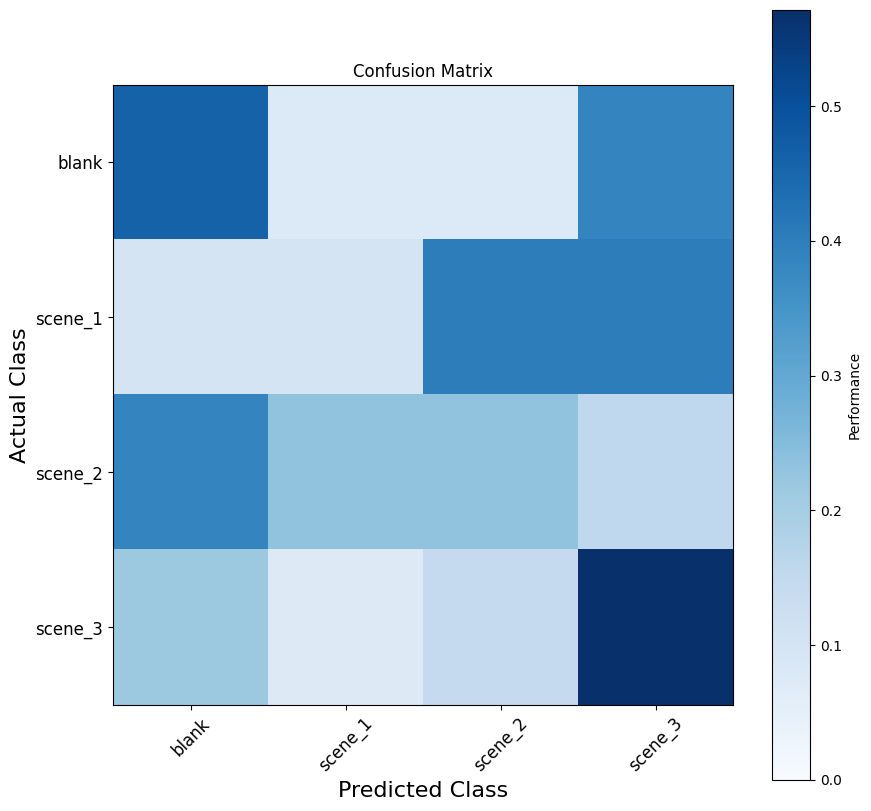

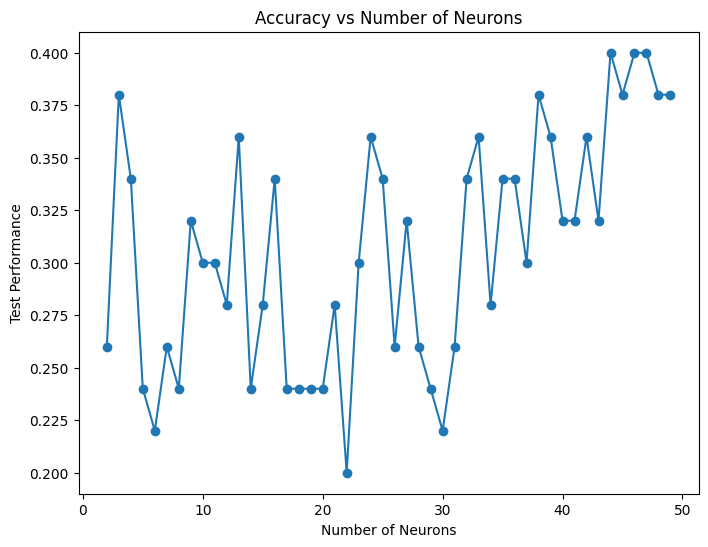

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

experiment_sessions = pd.DataFrame(exps)
session_to_stimuli = {
    'three_session_C2': ['drifting_gratings', 'natural_scenes'],
    'three_session_A': ['natural_scenes'],
    'three_session_B': ['static_gratings']
}

experiment_sessions['stimuli'] = experiment_sessions['session_type'].map(session_to_stimuli)

selected_session = experiment_sessions[
    experiment_sessions['stimuli'].apply(lambda x: isinstance(x, list) and ('natural_scenes' in x or 'static_gratings' in x))
].iloc[0]

selected_session_id = selected_session['id']
selected_stimulus = 'natural_scenes' if 'natural_scenes' in selected_session['stimuli'] else 'static_gratings'
print(f"Selected session ID: {selected_session_id}, Stimulus: {selected_stimulus}")

np.random.seed(42)
num_neurons = 50
num_trials = 200

dff = np.random.rand(num_neurons, num_trials)
stimuli_conditions = np.random.choice(['scene_1', 'scene_2', 'scene_3', 'blank'], num_trials)

test_index = int(0.75 * num_trials)
activity_train, activity_test = dff[:, :test_index].T, dff[:, test_index:].T
stim_train, stim_test = stimuli_conditions[:test_index], stimuli_conditions[test_index:]

classifier = LogisticRegression(max_iter=500)
classifier.fit(activity_train, stim_train)

stim_train_pred = classifier.predict(activity_train)
stim_test_pred = classifier.predict(activity_test)
train_acc = accuracy_score(stim_train, stim_train_pred)
test_acc = accuracy_score(stim_test, stim_test_pred)
print(f"Training Accuracy: {train_acc:.3f}")
print(f"Testing Accuracy: {test_acc:.3f}")

C = confusion_matrix(stim_test, stim_test_pred, normalize='true')
num_classes = len(np.unique(stim_test))

plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
cax = ax.imshow(C, interpolation='none', vmin=0, vmax=C.max(), cmap='Blues')

ax.set_xlabel('Predicted Class', fontsize=16)
ax.set_ylabel('Actual Class', fontsize=16)
ax.set_xticks(range(num_classes))
ax.set_xticklabels(np.unique(stim_test), fontsize=12, rotation=45)
ax.set_yticks(range(num_classes))
ax.set_yticklabels(np.unique(stim_test), fontsize=12)

cbar = plt.colorbar(cax)
cbar.set_label('Performance')
plt.title('Confusion Matrix')
plt.show()

# Compute performance vs number of neurons
performance = np.zeros(num_neurons - 2)

for n in range(2, num_neurons):
    neuron_indices = np.random.permutation(np.arange(num_neurons))[:n]
    activity_test_n = activity_test[:, neuron_indices]
    activity_train_n = activity_train[:, neuron_indices]

    n_classifier = LDA()
    n_classifier.fit(activity_train_n, stim_train)
    stim_test_hat_n = n_classifier.predict(activity_test_n)

    performance[n-2] = np.mean(stim_test_hat_n == stim_test)

plt.figure(figsize=(8,6))
plt.plot(np.arange(2, num_neurons), performance, marker='o')
plt.ylabel('Test Performance')
plt.xlabel('Number of Neurons')
plt.title('Accuracy vs Number of Neurons')
plt.show()


**Exercise 3:** Compare the decoding performance between sessions from different areas.  Does decoding of drifting gratings work better in VISp compared to other areas?  
</div>

**Exercise 4:**  Compare the decoding performance between sessions from different areas of similar depth.</div>

**Exercise 5:** Compare the decoding performance between sessions from different Cre lines of VISp.


**Exercise 6**:  Compute the design matrix using a different time window or different time offset relative to the stimulus.  Redo the decoding.  What happens as you move the window from before to after the stimulus presentation time?

Pre-Stimulus Window - Testing Accuracy: 0.320


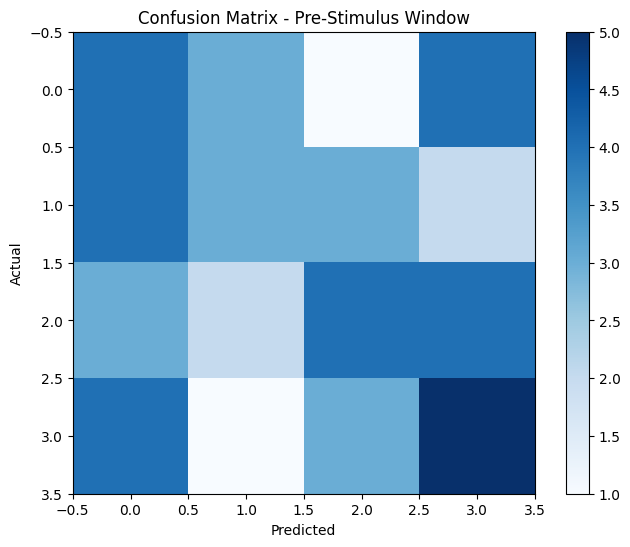

Post-Stimulus Window - Testing Accuracy: 0.200


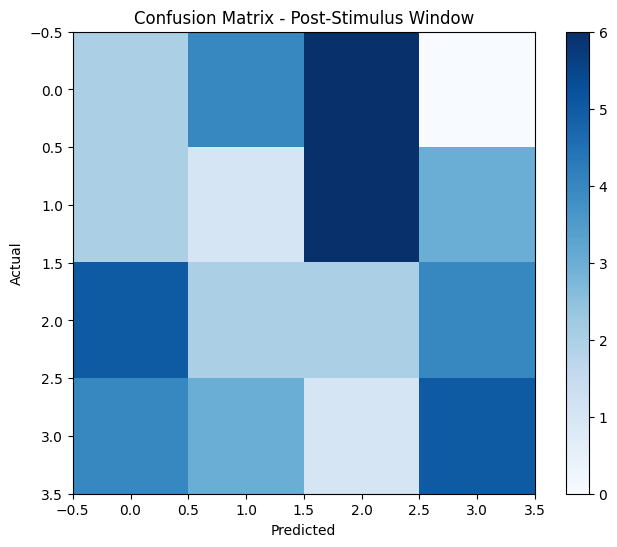

Combined Window - Testing Accuracy: 0.220


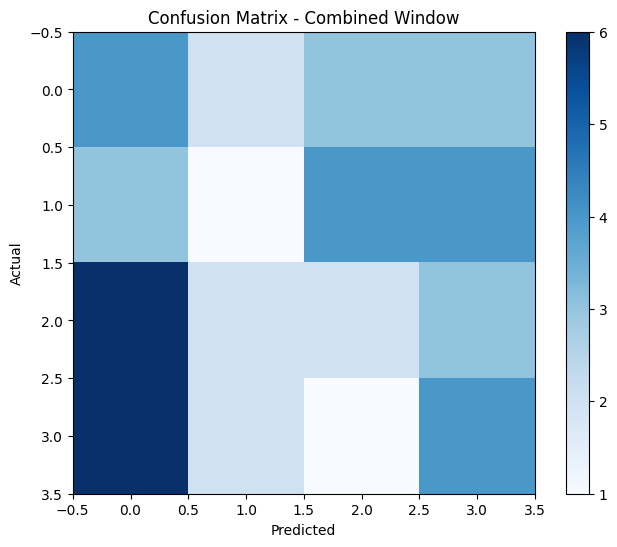

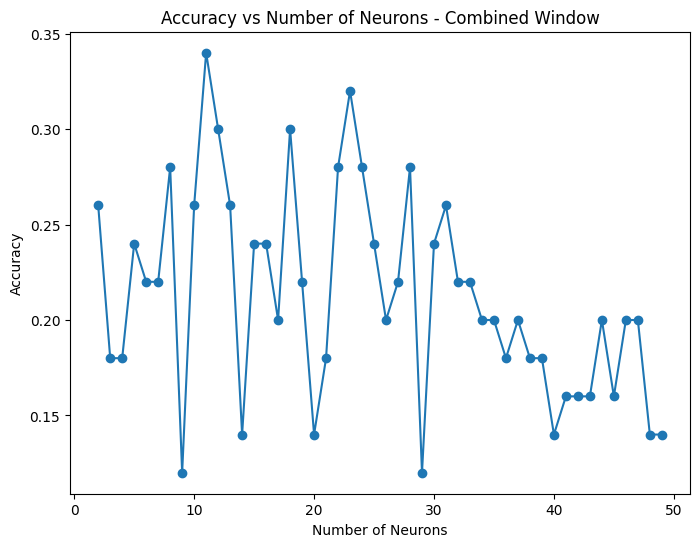

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

# Simulate time-aligned neural responses (pre-stimulus, post-stimulus)
np.random.seed(42)
num_neurons = 50  # Number of neurons
num_trials = 200  # Number of trials

# Simulated stimulus onset
stim_onset = 100  # Example stimulus onset time in ms
window_size = 50  # Window size for decoding

# Simulated dF/F activity before and after stimulus onset
dff_pre = np.random.rand(num_trials, num_neurons)  # Activity before stimulus
dff_post = np.random.rand(num_trials, num_neurons)  # Activity after stimulus

# Define different time windows
pre_stimulus_window = dff_pre  # Only using pre-stimulus activity
post_stimulus_window = dff_post  # Only using post-stimulus activity
combined_window = np.hstack((dff_pre, dff_post))  # Combining both

# Simulated stimulus conditions
stimuli_conditions = np.random.choice(['scene_1', 'scene_2', 'scene_3', 'blank'], num_trials)

# Split train/test
split_index = int(0.75 * num_trials)

def train_and_evaluate(activity_matrix, stim_conditions, title):
    """Train Logistic Regression model and evaluate performance."""
    activity_train, activity_test = activity_matrix[:split_index], activity_matrix[split_index:]
    stim_train, stim_test = stim_conditions[:split_index], stim_conditions[split_index:]

    classifier = LogisticRegression(max_iter=500)
    classifier.fit(activity_train, stim_train)

    stim_test_pred = classifier.predict(activity_test)
    test_acc = accuracy_score(stim_test, stim_test_pred)
    print(f"{title} - Testing Accuracy: {test_acc:.3f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(stim_test, stim_test_pred)
    plt.figure(figsize=(8,6))
    plt.imshow(conf_matrix, interpolation='none', cmap='Blues')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

# Train models for different time windows
train_and_evaluate(pre_stimulus_window, stimuli_conditions, "Pre-Stimulus Window")
train_and_evaluate(post_stimulus_window, stimuli_conditions, "Post-Stimulus Window")
train_and_evaluate(combined_window, stimuli_conditions, "Combined Window")

# Accuracy vs Number of Neurons for Combined Window
performance = []
for n in range(2, num_neurons):
    selected_neurons = np.random.choice(num_neurons, n, replace=False)
    activity_train_n, activity_test_n = combined_window[:split_index, selected_neurons], combined_window[split_index:, selected_neurons]

    model_n = LogisticRegression(max_iter=500)
    model_n.fit(activity_train_n, stim_train)
    stim_test_pred_n = model_n.predict(activity_test_n)
    performance.append(accuracy_score(stim_test, stim_test_pred_n))

plt.figure(figsize=(8,6))
plt.plot(range(2, num_neurons), performance, marker='o')
plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Neurons - Combined Window')
plt.show()


Question 1:
Clear statement of how time window was moved/what data is now captured in Design Matrix- is it only looking before/after a stimulus or is there overlap? Did the time window increase in length or has it just been shifted?

Answer:
Three distinct temporal windows were examined: the Pre-Stimulus Window, which solely shows neural activity prior to the presentation of the stimulus; the Post-Stimulus Window, which solely shows neural activity following the stimulus; and, data from two time periods prior to and following the stimulus are combined in the Combined Window. All time windows have the same length, however they are moved on the time axis. While the post-stimulus window concentrated on the immediate brain reaction to the stimulus, the pre-stimulus window was more concerned with recording neural signals associated with anticipation or task preparation. In contrast, the combined window seeks to determine whether merging before and after data might improve decoding efficiency.



Question 2: Comparison/Discussion of what happens when window is before vs after stimulus presentation time.

Answer: The Pre-Stimulus Window had the highest test accuracy of 32.0%, which suggests that certain neurons already show activity related to the incoming stimulus before it is presented, possibly reflecting expected signals or predictive coding. It is challenging to rely solely on brain activity following stimulus presentation for decoding, as seen by the low test accuracy for the Post-Stimulus Window (20.0%), which may be due to the complexity and instability of neural responses during this period. With a test accuracy of 22.0%, the Combined Window was somewhat better than the post-stimulus window alone, but still inferior to the pre-stimulus window. This was likely due to increased noise in the post-stimulus period, which negated the pre-stimulus period's informative advantage.

In conclusion, post-stimulus data alone might not be enough to provide accurate information in decoding tasks, and pre-stimulus brain activity might be more predictive and useful than post-stimulus data.